In [1]:
import pandas as pd
import altair as alt
import numpy as np

apiKey = open("/Users/kyledunn/fredApiKey.txt", "r").read().strip()

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
    
def getSeries(series="", apiKey=apiKey, description=None):
    fetchCommand = "https://api.stlouisfed.org/fred/series/observations?series_id={s}&realtime_end=9999-12-31&api_key={k}&file_type=txt" 
    
    resp = urlopen(fetchCommand.format(s=series, k=apiKey))
    zipfile = ZipFile(BytesIO(resp.read()))
    
    filesInZip = zipfile.namelist()
    
    data = zipfile.open(filesInZip[1])
    
    if description is None:
        description = series
    
    df = pd.read_csv(data, sep="\t", header=None, skiprows=1,
                       names=["date", description, "rt_start", "rt_end"], na_values=".")
    
    df['date'] = pd.to_datetime(df.date)
    
    return df.set_index("date")

In [2]:
df_cpi = getSeries("CWUR0000SA0")

In [3]:
# https://www.census.gov/retail/index.html

#df = pd.read_excel('https://www.census.gov/retail/mrts/www/mrtssales92-present.xls', sheet_name='2018').iloc[5:109]

#yearColumns = lambda y : map(lambda s: s.format(y), ['Jan. {}', 'Feb. {}', 'Mar. {}', 'Apr. {}', 'May {}', 'Jun. {}', 'Jul. {}', 'Aug. {}', 'Sep. {}', 'Oct. {}', 'Nov. {}', 'Dec. {}', 'TOTAL'])

#df.columns = ['NAICS', 'Description'] + list(yearColumns(2018))

In [3]:
yearColumns = lambda y : map(lambda s: s.format(y), ['Jan. {}', 'Feb. {}', 'Mar. {}', 'Apr. {}', 'May {}', 'Jun. {}', 'Jul. {}', 'Aug. {}', 'Sep. {}', 'Oct. {}', 'Nov. {}', 'Dec. {}', 'Total {}'])
standardColumns = lambda y : ['NAICS', 'Description'] + list(yearColumns(y))

# Note, may need to add to 2019 as new data is released
oneOffYears = {
    '2019': standardColumns('2019')[:2] + ['Jan. 2019', 'Feb. 2019', 'Mar. 2019', 'Apr. 2019', 'May 2019', 'Jun. 2019', 'Jul. 2019', 'Aug. 2019', 'Sep. 2019', 'Oct. 2019', 'Nov. 2019', '2019 CUM', '2019 PY CUM'],
    '2016': standardColumns('2016') + ['IGNORE']
}

dfs = pd.read_excel('https://www.census.gov/retail/mrts/www/mrtssales92-present.xls', sheet_name=None)

allDfs = []
for y in dfs.keys():
    #print(dfs[y].columns)
    dfs[y].columns = oneOffYears.get(y) or standardColumns(y)
    dfs[y] = dfs[y].drop('NAICS', axis=1)
    #print(dfs[y].iloc[5:109].set_index('Description').index.is_unique)
    allDfs.append(dfs[y].iloc[5:109].set_index('Description'))
    
#combined = pd.concat(allDfs, axis=1, sort=False) #.T.drop('NAICS')

old = pd.concat(allDfs[2:], axis=1) #.T.drop('NAICS')
new = pd.concat(allDfs[:2], axis=1)

combined = new.join(old).drop('ADJUSTED(2)').T

combined.head(10)

Description All other gen. merchandise stores  \
Jan. 2019                                6223   
Feb. 2019                                6119   
Mar. 2019                                6970   
Apr. 2019                                7050   
May 2019                                 7483   
Jun. 2019                                7061   
Jul. 2019                                6954   
Aug. 2019                                7048   
Sep. 2019                                6608   
Oct. 2019                                7170   

Description All other gen. merchandise stores  \
Jan. 2019                                6223   
Feb. 2019                                6119   
Mar. 2019                                6970   
Apr. 2019                                7050   
May 2019                                 7483   
Jun. 2019                                7061   
Jul. 2019                                6954   
Aug. 2019                                7048   
Sep. 2019                                6608   
Oct. 2019                                7170   

Description All other gen. merchandise stores  \
Jan. 2019                                7048   
Feb. 2019                                6985   
Mar. 2019                                7112   
Apr. 2019                                7209   
May 2019                                 7168   
Jun. 2019                                7169   
Jul. 2019                                7214   
Aug. 2019                                7163   
Sep. 2019                                7098   
Oct. 2019                                7120   

Description All other gen. merchandise stores  \
Jan. 2019                                7048   
Feb. 2019                                6985   
Mar. 2019                                7112   
Apr. 2019                                7209   
May 2019                                 7168   
Jun. 2019                                7169   
Jul. 2019                                7214   
Aug. 2019                                7163   
Sep. 2019                                7098   
Oct. 2019                                7120   

Description All other home furnishings stores  \
Jan. 2019                                2270   
Feb. 2019                                2112   
Mar. 2019                                2379   
Apr. 2019                                2298   
May 2019                                 2479   
Jun. 2019                                2208   
Jul. 2019                                2441   
Aug. 2019                                2546   
Sep. 2019                                2288   
Oct. 2019                                2464   

Description Automobile and other motor vehicle dealers  \
Jan. 2019                                        81196   
Feb. 2019                                        83110   
Mar. 2019                                       102820   
Apr. 2019                                        96015   
May 2019                                        104373   
Jun. 2019                                        97749   
Jul. 2019                                       102036   
Aug. 2019                                       107458   
Sep. 2019                                        92953   
Oct. 2019                                        96607   

Description Automobile and other motor vehicle dealers  \
Jan. 2019                                        81196   
Feb. 2019                                        83110   
Mar. 2019                                       102820   
Apr. 2019                                        96015   
May 2019                                        104373   
Jun. 2019                                        97749   
Jul. 2019                                       102036   
Aug. 2019                                       107458   
Sep. 2019                                        92953   
Oct. 2019                                        96607   

Description Automobile

In [4]:
import re

tsNormalized = combined[combined.index.map(lambda v: re.search('[A-z]{3}.? \d{4}$', v) is not None and 'Total' not in v)].copy()

tsNormalized['dt'] = tsNormalized.index.map(lambda v: pd.to_datetime(v.replace('(p)', ''), format='%b. %Y') 
                                            if '.' in v else pd.to_datetime(v, format='%b %Y'))

In [5]:
dt = tsNormalized.set_index('dt')
dt = dt.apply(pd.to_numeric, errors='coerce')
dt.head()

Description  All other gen. merchandise stores  \
dt                                               
2019-01-01                                6223   
2019-02-01                                6119   
2019-03-01                                6970   
2019-04-01                                7050   
2019-05-01                                7483   

Description  All other gen. merchandise stores  \
dt                                               
2019-01-01                                6223   
2019-02-01                                6119   
2019-03-01                                6970   
2019-04-01                                7050   
2019-05-01                                7483   

Description  All other gen. merchandise stores  \
dt                                               
2019-01-01                                7048   
2019-02-01                                6985   
2019-03-01                                7112   
2019-04-01                                7209   
2019-05-01                                7168   

Description  All other gen. merchandise stores  \
dt                                               
2019-01-01                                7048   
2019-02-01                                6985   
2019-03-01                                7112   
2019-04-01                                7209   
2019-05-01                                7168   

Description  All other home furnishings stores  \
dt                                               
2019-01-01                              2270.0   
2019-02-01                              2112.0   
2019-03-01                              2379.0   
2019-04-01                              2298.0   
2019-05-01                              2479.0   

Description  Automobile and other motor vehicle dealers  \
dt                                                        
2019-01-01                                        81196   
2019-02-01                                        83110   
2019-03-01                                       102820   
2019-04-01                                        96015   
2019-05-01                                       104373   

Description  Automobile and other motor vehicle dealers  \
dt                                                        
2019-01-01                                        81196   
2019-02-01                                        83110   
2019-03-01                                       102820   
2019-04-01                                        96015   
2019-05-01                                       104373   

Description  Automobile and other motor vehicle dealers  \
dt                                                        
2019-01-01                                        92689   
2019-02-01                                        92242   
2019-03-01                                        95469   
2019-04-01                                        95064   
2019-05-01                                        95492   

Description  Automobile and other motor vehicle dealers  Automobile dealers  \
dt                                                                            
2019-01-01                                        92689               76785   
2019-02-01                                        92242               78166   
2019-03-01                                        95469               95730   
2019-04-01                                        95064               88472   
2019-05-01                                        95492               95891   

Description  ...  Used car dealers  Used merchandise stores  \
dt           ...                                              
2019-01-01   ...              8647                     1371   
2019-02-01   ...              9445                     1334   
2019-03-01   ...             11525                     1508   
2019-04-01   ...             10009                     1562   
2019-05-01   ...             10223                     1418   

Descrip

In [6]:
# Melt and re-aggregate to combine duplicate categories
df_melted = dt.reset_index().melt(id_vars='dt')
df_agg = df_melted.groupby(['dt', 'Description']).agg(sum).reset_index('Description')
df_agg.head()

Description     value
dt                                                              
1992-01-01           All other gen. merchandise stores    9586.0
1992-01-01           All other home furnishings stores       0.0
1992-01-01  Automobile and other motor vehicle dealers  113910.0
1992-01-01                          Automobile dealers   25800.0
1992-01-01     Automotive parts, acc., and tire stores   12668.0

In [7]:
df_combined = df_agg.pivot(index=df_agg.index, columns='Description')
df_combined.columns = df_combined.columns.droplevel()
df_combined.head()

Description  All other gen. merchandise stores  \
dt                                               
1992-01-01                              9586.0   
1992-02-01                              9540.0   
1992-03-01                              9444.0   
1992-04-01                              9936.0   
1992-05-01                              9986.0   

Description  All other home furnishings stores  \
dt                                               
1992-01-01                                 0.0   
1992-02-01                                 0.0   
1992-03-01                                 0.0   
1992-04-01                                 0.0   
1992-05-01                                 0.0   

Description  Automobile and other motor vehicle dealers  Automobile dealers  \
dt                                                                            
1992-01-01                                     113910.0             25800.0   
1992-02-01                                     117320.0             27031.0   
1992-03-01                                     123150.0             30195.0   
1992-04-01                                     125816.0             30583.0   
1992-05-01                                     127460.0             31095.0   

Description  Automotive parts, acc., and tire stores  \
dt                                                     
1992-01-01                                   12668.0   
1992-02-01                                   12748.0   
1992-03-01                                   13794.0   
1992-04-01                                   13900.0   
1992-05-01                                   14174.0   

Description  Beer, wine and liquor stores  Beer, wine, and liquor stores  \
dt                                                                         
1992-01-01                         1713.0                         1509.0   
1992-02-01                         1763.0                         1541.0   
1992-03-01                         1753.0                         1597.0   
1992-04-01                         1784.0                         1675.0   
1992-05-01                         1783.0                         1822.0   

Description  Book stores  \
dt                         
1992-01-01         790.0   
1992-02-01         539.0   
1992-03-01         535.0   
1992-04-01         523.0   
1992-05-01         552.0   

Description  Building mat. and garden equip. and supplies dealers  \
dt                                                                  
1992-01-01                                             39618.0      
1992-02-01                                             39854.0      
1992-03-01                                             43188.0      
1992-04-01                                             44736.0      
1992-05-01                                             46208.0      

Description  Building mat. and supplies dealers  ...  Retail sales, total  \
dt                                               ...                        
1992-01-01                              33392.0  ...             555216.0   
1992-02-01                              33302.0  ...             556934.0   
1992-03-01                              35712.0  ...             578586.0   
1992-04-01                              36688.0  ...             590414.0   
1992-05-01                              37550.0  ...             602860.0   

Description  Retail sales, total (excl. motor vehicle and parts dealers)  \
dt                                                                         
1992-01-01                                            428638.0             
1992-02-01                                            426866.0             
1992-03-01                                            441642.0             
1992-04-01                                            450698.0             
1992-05-01                                            461226.0             

Description  Shoe stores  Sporting goods stores  \
dt           

### What is the trend for home furnishing retail stores?

In [13]:
alt.Chart(df_combined.reset_index()).mark_line().encode(
    alt.X('dt', axis=alt.Axis(title='')),
    alt.Y('Furniture, home furn, electronics, and appliance stores:Q'),
    tooltip=[alt.Tooltip('dt:T'), alt.Tooltip('Furniture, home furn, electronics, and appliance stores:Q')]
).properties(
    height=500,
    width=750
)

alt.Chart(...)

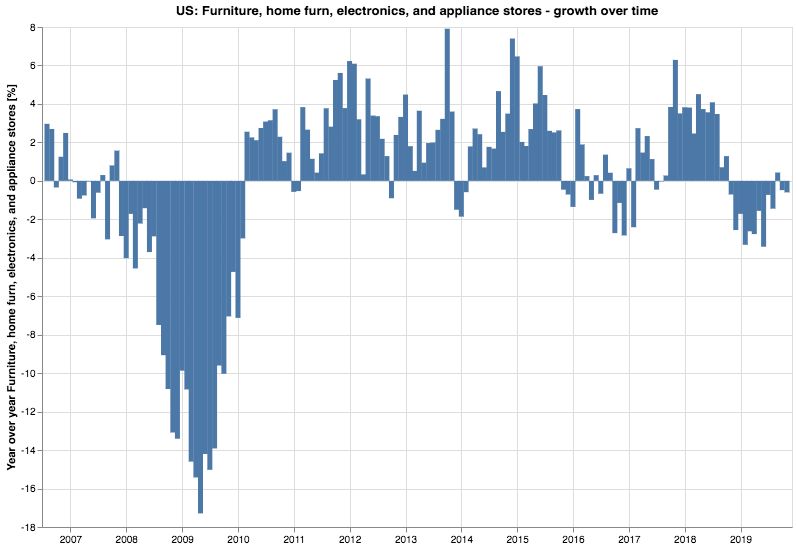

In [9]:
def doYoYChartFor(metric, df):
    yoy = df[[metric]].pct_change(12).apply(lambda v: v*100.).sort_index()

    return alt.Chart(yoy[-160:].reset_index()).mark_bar().encode(
        alt.X('dt:T', axis=alt.Axis(title='')),
        alt.Y('{}:Q'.format(metric), axis=alt.Axis(title='Year over year {} [%]'.format(metric))),
        tooltip=[alt.Tooltip('dt:T'), alt.Tooltip('{}:Q'.format(metric))]
    ).properties(
        title='US: {} - growth over time'.format(metric),
        height=500,
        width=750
    )
    
doYoYChartFor('Furniture, home furn, electronics, and appliance stores', df_combined)

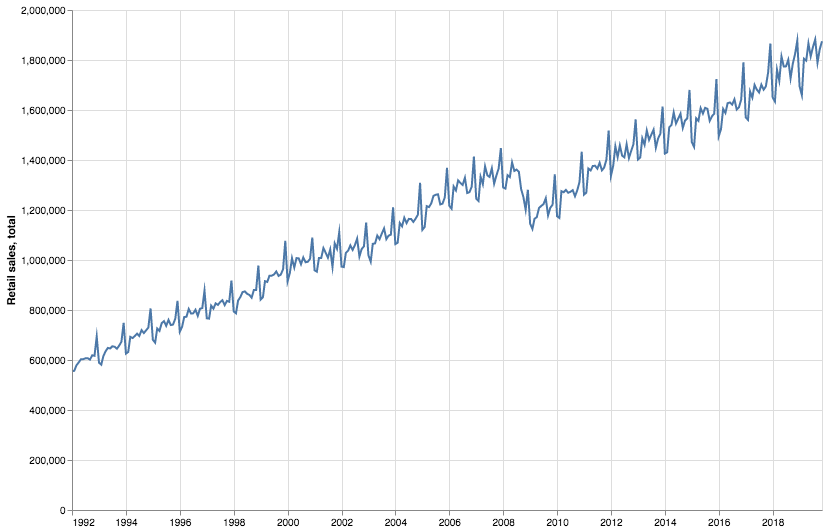

In [10]:
alt.Chart(df_combined.reset_index()).mark_line().encode(
    alt.X('dt', axis=alt.Axis(title='')),
    alt.Y('Retail sales, total:Q')
).properties(
    height=500,
    width=750
)

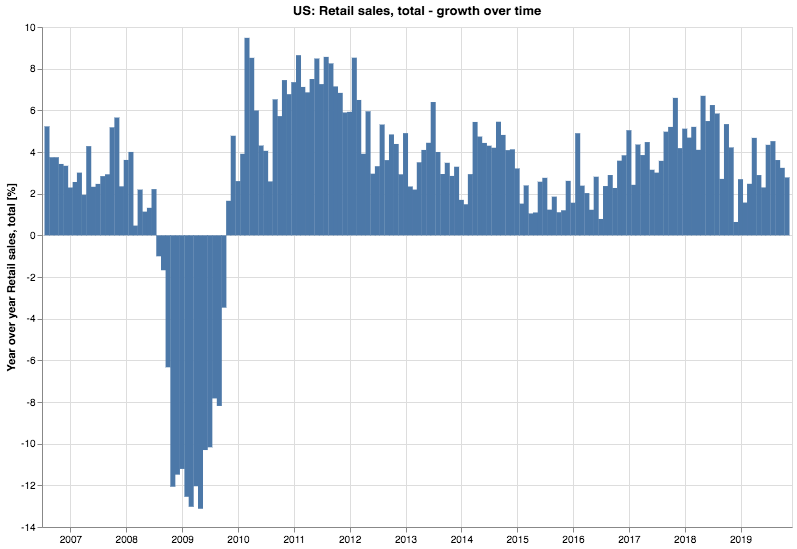

In [11]:
doYoYChartFor('Retail sales, total', df_combined)

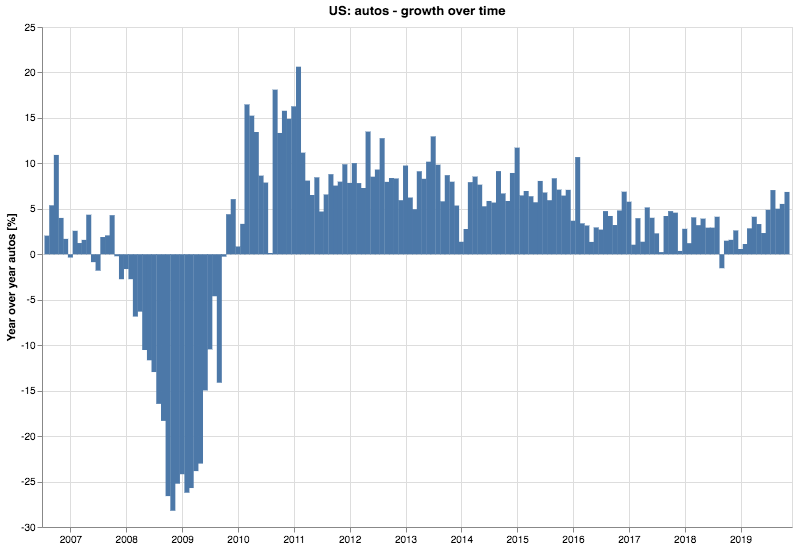

In [12]:
as_yoy = df_combined.copy()

as_yoy['autos'] = (as_yoy['Retail sales, total'] -\
                   as_yoy['Retail sales, total (excl. motor vehicle and parts dealers)'])

as_df = as_yoy['autos'].reset_index()

doYoYChartFor('autos', as_df.set_index('dt'))

In [16]:
df_cpi.tail()

CWUR0000SA0    rt_start rt_end
date                                      
2019-08-01      250.112  2019-09-12    NaN
2019-09-01      250.251  2019-10-10    NaN
2019-10-01      250.894  2019-11-13    NaN
2019-11-01      250.644  2019-12-11    NaN
2019-12-01      250.452  2020-01-14    NaN

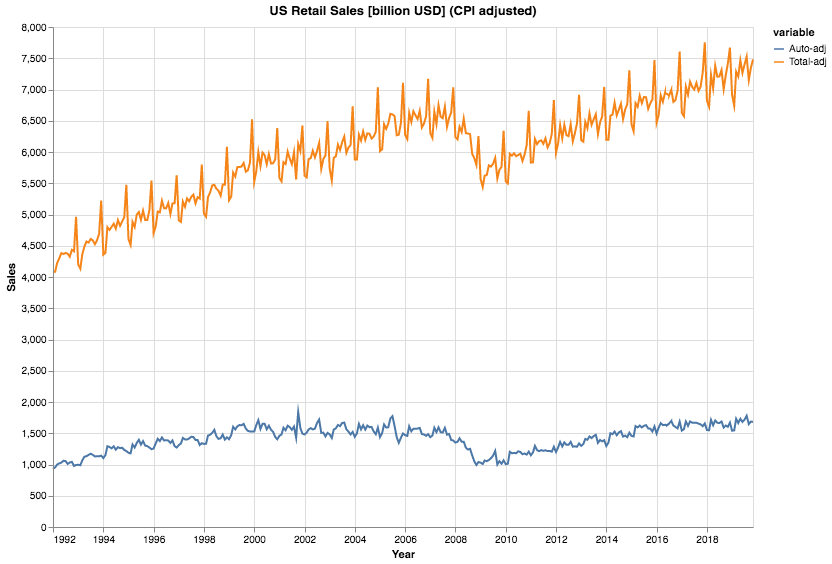

In [13]:
toCompare = [
    'Retail sales, total',
    'Retail sales, total (excl. motor vehicle and parts dealers)',
    'Retail sales and food services excl motor vehicle and parts'
]

tmp = df_combined[['Retail sales, total', 'Retail sales, total (excl. motor vehicle and parts dealers)']].copy()
tmp.columns = ['Retail sales, total', 'Retail sales excluding motor vehicles']

tmp['Retail sales, motor vehicles and parts'] = tmp['Retail sales, total'] - tmp['Retail sales excluding motor vehicles']
tmp = tmp.join(df_cpi['CWUR0000SA0'])
tmp.columns = ['Retail Total', 'Retail Excluding Motor Vehicles', 'Retail Motor Vehicles', 'CPI']

tmp['Total-adj'] = tmp['Retail Total'] / tmp['CPI']
tmp['Auto-adj'] = tmp['Retail Motor Vehicles'] / tmp['CPI']

#print(tmp.reset_index().columns)

chartable = tmp.reset_index()[['index', 'Total-adj', 'Auto-adj']].melt(id_vars='index')

# [['index', 'Total-adj', 'Auto-adj']]
alt.Chart(chartable).mark_line().encode(
    alt.X('index:T', axis=alt.Axis(title='Year')),
    alt.Y('value:Q', axis=alt.Axis(title='Sales')),
    alt.Color('variable:N')
).properties(
    title='US Retail Sales [billion USD] (CPI adjusted)',
    height=500,
    width=700
)

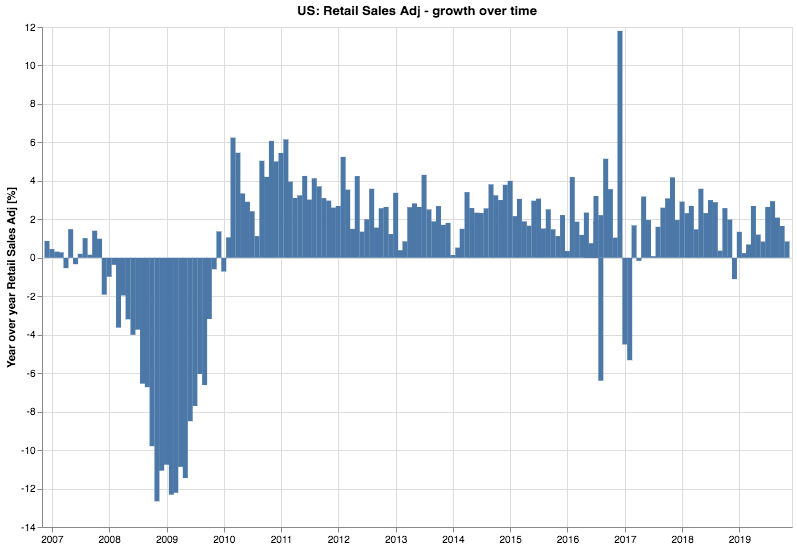

In [14]:
df_adj = tmp['Total-adj'].reset_index().copy()
df_adj.columns = ['dt', 'Retail Sales Adj']

#df_adj.head()
doYoYChartFor('Retail Sales Adj', df_adj.set_index('dt'))

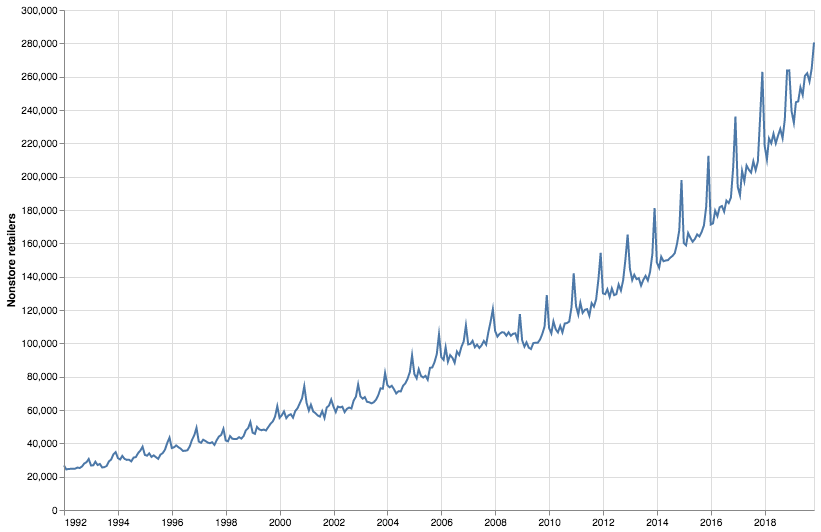

In [21]:
# Department stores

alt.Chart(df_combined.reset_index()).mark_line().encode(
    alt.X('dt', axis=alt.Axis(title='')),
    alt.Y('Nonstore retailers:Q')
).properties(
    height=500,
    width=750
)

In [15]:
dfm = pd.read_excel('https://www.census.gov/manufacturing/m3/prel/historical_data/histshts/naics/naicsnop.xls', header=None)
dfm.columns = ['Code', 'Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
dfm = dfm.set_index('Year')

In [16]:
dfm.loc[2019].head()

Code       Jan     Feb     Mar     Apr     May     Jun     Jul  \
Year                                                                     
2019  AMTMNO  501716.0  496780  503295  497166  490693  493351  500153   
2019  AMXTNO  409945.0  411112  412500  413305  413163  412663  413552   
2019  AMXDNO  487582.0  484107  486704  479916  476266  481535  486449   
2019  AMTUNO  181924.0  175106  179278  173554  167262  169906  175020   
2019  AMDMNO  256134.0  249569  253834  246609  240923  245231  250328   

         Aug     Sep     Oct     Nov  Dec  
Year                                       
2019  499585  495574  496644  493029  NaN  
2019  412814  411537  412609  413987  NaN  
2019  483182  478368  478963  482118  NaN  
2019  175862  173464  174593  168879  NaN  
2019  250733  247059  247442  242247  NaN

In [17]:
dfm_release = pd.read_excel('https://www.census.gov/manufacturing/m3/reldates.xls', skiprows=3).iloc[:-3]
dfm_release.tail(14)

Survey month  \
0   2019-09-01 00:00:00   
1   2019-10-01 00:00:00   
2   2019-11-01 00:00:00   
3   2019-12-01 00:00:00   
4   2020-01-01 00:00:00   
5   2020-02-01 00:00:00   
6   2020-03-01 00:00:00   
7   2020-04-01 00:00:00   
8   2020-05-01 00:00:00   
9   2020-06-01 00:00:00   
10  2020-07-01 00:00:00   
11  2020-08-01 00:00:00   
12  2020-09-01 00:00:00   
13  2020-10-01 00:00:00   

   Advance Report                           (8:30 a.m. release time)  \
0                                      Thu 10/24/2019                  
1                                      Wed 11/27/2019                  
2                                     Mon 12/23/2019*                  
3                                       Tue 1/28/2020                  
4                                       Thu 2/27/2020                  
5                                       Wed 3/25/2020                  
6                                       Fri 4/24/2020                  
7                                       Thu 5/28/2020                  
8                                       Thu 6/25/2020                  
9                                       Mon 7/27/2020                  
10                                      Wed 8/26/2020                  
11                                      Fri 9/25/2020                  
12                                     Tue 10/27/2020                  
13                                     Wed 11/25/2020                  

   Full Report                                (10:00 a.m. release time)  
0                                       Mon 11/4/2019                    
1                                       Thu 12/5/2019                    
2                                        Tue 1/7/2020                    
3                                        Tue 2/4/2020                    
4                                        Thu 3/5/2020                    
5                                        Thu 4/2/2020                    
6                                        Mon 5/4/2020                    
7                                        Wed 6/3/2020                    
8                                        Thu 7/2/2020                    
9                                        Tue 8/4/2020                    
10                                       Wed 9/2/2020                    
11                                      Fri 10/2/2020                    
12                                      Tue 11/3/2020                    
13                                      Fri 12/4/2020

In [18]:
# Code defs: https://www.census.gov/manufacturing/m3/historical_data/naicshist.pdf

subset = dfm[dfm.Code == 'UMTMNO'].drop('Code', axis=1).reset_index()
melted = subset.melt(id_vars=['Year'])
melted['dt'] = pd.to_datetime(melted['Year'].astype(str) + melted['variable'], format='%Y%b')

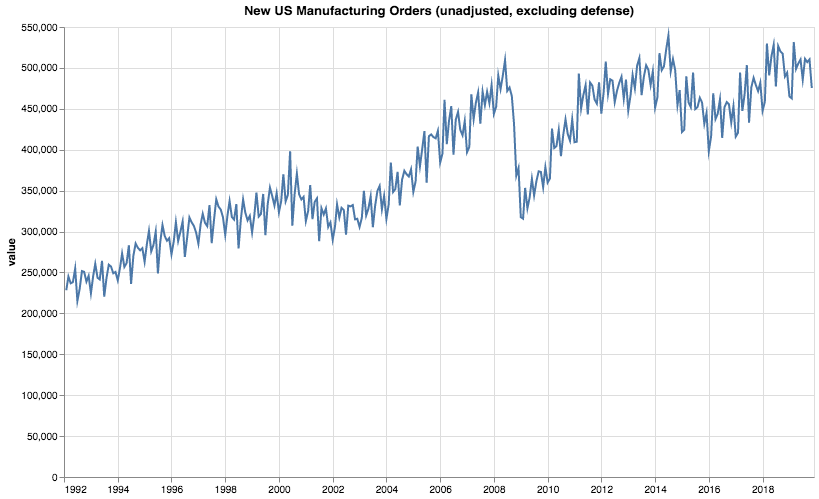

In [19]:
alt.Chart(melted.sort_values('dt')).mark_line().encode(
    alt.X('dt', axis=alt.Axis(title='')),
    alt.Y('value:Q'),
    tooltip=[alt.Tooltip('value:Q'), alt.Tooltip('dt:T', format='%B - %Y')]
).properties(
    title='New US Manufacturing Orders (unadjusted, excluding defense)',
    height=450,
    width=750,
)

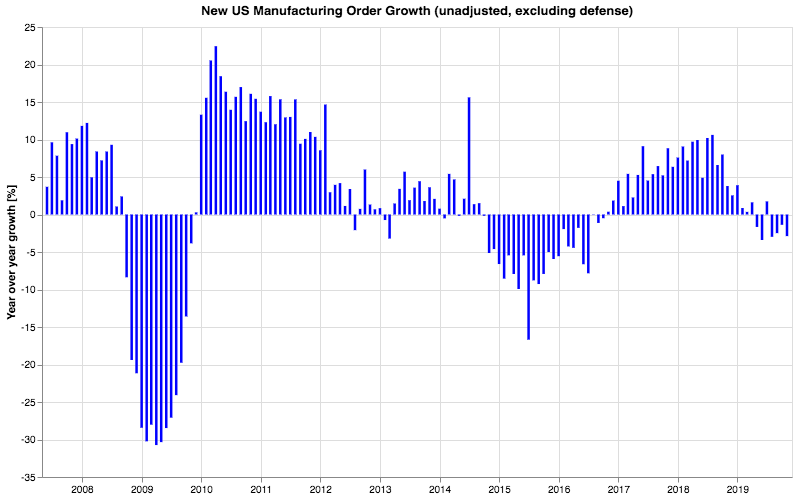

In [22]:
yoy_orders = melted.set_index('dt')['value'].sort_index().dropna()\
             .pct_change(12).apply(lambda v: v * 100.).reset_index()

alt.Chart(yoy_orders[-150:]).mark_bar(color='blue', size=2.5).encode(
    alt.X('dt', axis=alt.Axis(title='')),
    alt.Y('value:Q', axis=alt.Axis(title='Year over year growth [%]')),
    tooltip=[alt.Tooltip('dt:T', format='%B - %Y', title='Period'), alt.Tooltip('value:Q', title='% Change')]
).properties(
    title='New US Manufacturing Order Growth (unadjusted, excluding defense)',
    height=450,
    width=750,
    background="white"
)

In [28]:
dfc_release = pd.read_html('https://www.census.gov/construction/c30/release.html')[0]
dfc_release.head()

Empty DataFrame
Columns: [(Reporting Period, September, October, November, December, January 2020, February, March, April, May, June, July, August, September, October), (Release Date, November 1, December 2, January 3, 2020, February 3, March 2, April 1, May 1, June 1, July 1, August 3, September 1, October 1, November 2, December 1), (Time, 10:00 a.m., 10:00 a.m., 10:00 a.m., 10:00 a.m., 10:00 a.m., 10:00 a.m., 10:00 a.m., 10:00 a.m., 10:00 a.m., 10:00 a.m., 10:00 a.m., 10:00 a.m., 10:00 a.m., 10:00 a.m.)]
Index: []

In [23]:
# https://www.census.gov/construction/c30/release.html

dfc = pd.read_excel('https://www.census.gov/construction/c30/xls/totsatime.xls', skiprows=3).iloc[:311]

In [24]:
dfc['dt'] = dfc.Date.map(lambda d:
                         pd.to_datetime(d, format='%b-%y') if d[-1] not in ['r', 'p'] 
                         else pd.to_datetime(d[:-1], format='%b-%y'))

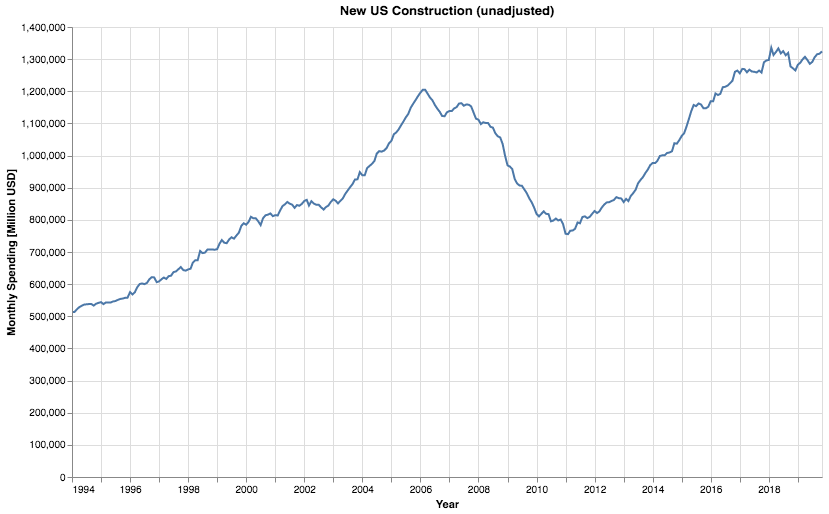

In [25]:
alt.Chart(dfc).mark_line().encode(
    alt.X('dt', axis=alt.Axis(title='Year')),
    alt.Y('Total\n\rConstruction1:Q', axis=alt.Axis(title='Monthly Spending [Million USD]')),
    tooltip=[alt.Tooltip('dt:T', format='%B - %Y', title='Period'), alt.Tooltip('Total\n\rConstruction1:Q', title='% Change')]
).properties(
    title='New US Construction (unadjusted)',
    height=450,
    width=750,
)

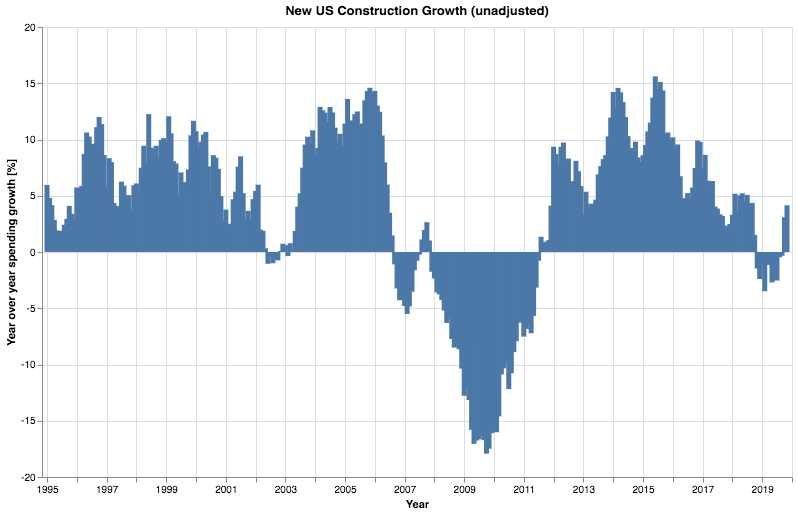

In [26]:
yoy_construction = dfc.set_index('dt')['Total\n\rConstruction1'].sort_index().dropna()\
                   .pct_change(12).apply(lambda v: v * 100.).reset_index()


alt.Chart(yoy_construction).mark_bar().encode(
    alt.X('dt', axis=alt.Axis(title='Year')),
    alt.Y('Total\n\rConstruction1:Q', axis=alt.Axis(title='Year over year spending growth [%]')),
    tooltip=[alt.Tooltip('dt:T', format='%B - %Y', title='Period'), alt.Tooltip('Total\n\rConstruction1:Q', title='% Change')]
).properties(
    title='New US Construction Growth (unadjusted)',
    height=450,
    width=750,
    background="white"
)

In [61]:
# https://www.census.gov/services/qss/historic_data.html

urlFor = lambda y, q: 'http://www2.census.gov/services/qss/{0}/all_{0}q{1}.xls'.format(y, q) if y < 2019\
                 else 'http://www2.census.gov/services/qss/{0}/all_{0}Q{1}.xls'.format(y, q)

# [1:] -> omit Q1 2004, :-1 -> omit Q4 2019
urls = [(urlFor(y, q), y, q) for y in range(2004, 2020) for q in range(1, 5)][1:-1]

# Manually append the most recent reporting period
#urls = urls + [('https://www.census.gov/services/qss/qss-current.xls', 2019, 1)]

In [47]:
import re

In [86]:
%%time

# Depending on the year and quarter, the most useful sheet name 
# evolves from table1 -> table1B -> table1b -> tableA1
def sheetNameFor(y, q):
    if y <= 2007:
        return 'table1-{0}Q{1}'.format(y, q)
        
    elif y == 2008 and q != 4:
        if q != 4:
            return 'table1-{0}Q{1}'.format(y, q)
        else:
            return 'table1B-{0}Q{1}'.format(y, q)
            
    elif y < 2016:
        return 'table1B-{0}Q{1}'.format(y, q)
      
    elif y == 2016:
        if q != 4:
            return 'table1B-{0}Q{1}'.format(y, q)
        else:
             return 'table1b-{0}Q{1}'.format(y, q)
    else:
        return 'table1b-{0}Q{1}'.format(y, q)

rest = list(map(lambda u: (u[1], u[2], pd.read_excel(u[0], sheet_name=sheetNameFor(u[1], u[2]))), urls))

CPU times: user 6.39 s, sys: 674 ms, total: 7.06 s
Wall time: 41.3 s


In [87]:
# Depending on the year and quarter, we need to skip differing numbers of "header" rows
def indexFor(y, q):
    if y < 2006:
        return 6
    elif y == 2006 and q < 2:
        return 6
    else:
        return 4

revenues = list(map(lambda d: (d[0], d[1], d[2].iloc[indexFor(d[0], d[1]):, 0:8]), rest))

In [88]:
%%time

# To make the various NAICS codes align, we have to cleanup certain codes and mark aggregate categories accordingly
def remapCategory(code):
    if 'pt' in code:
        return re.sub('[^\d]+', '', code) + 'pt'
    elif code in ['11', '21', '22', '23', '31-33', '42', '44-45', '48-49', '51', '52', '53',\
                '54', '55', '56', '61', '62', '71', '72', '81', '92']:
        return code + 'c'
    else:
        return code

cleanIt = lambda s: re.sub('(,$|,\sand.*$)', '', re.sub('\s?\(.*$', '', re.sub('\s*\d+$', '', re.sub('\s+', ' ', s.replace('…', '').replace('.', '').strip()))))

# Depending on the year and quarter we need to provide consistent column headers looking back in time from current
def getPrevious(y, q):
    if q == 1:
        return ['{}Q1'.format(y)] + ['{0}Q{1}'.format(y-1, n+1) for n in reversed(range(4))]
    elif q == 2:
        return ['{}Q2'.format(y)] + ['{}Q1'.format(y)] + ['{0}Q{1}'.format(y-1, n+1) for n in reversed(range(4))][:-1]
    elif q == 3:
        return ['{}Q3'.format(y)] + ['{}Q2'.format(y)] + ['{}Q1'.format(y)] + ['{0}Q{1}'.format(y-1, n+1) for n in reversed(range(4))][:-2]
    elif q == 4:
        return ['{0}Q{1}'.format(y, n+1) for n in reversed(range(4))] + ['{}Q4'.format(y-1)]

crevs = []
for y, q, df in revenues:
    tmp = df.copy()
    tmp.columns = ['Code', 'Business', '{0}Q{1}YTD'.format(y, q)] + getPrevious(y, q)
    tmp['Source'] = tmp.Code.map(lambda c: "{0}Q{1}".format(y, q))
    
    tmp = tmp[pd.notnull(tmp.Business)]
    tmp = tmp[pd.notna(tmp.Business)]
    tmp = tmp[pd.notnull(tmp.Code)]

    # Exclude records reporting "previous definitions"
    tmp = tmp[tmp.Code.map(lambda c: '*' not in str(c))]

    tmp['Code'] = tmp.Code.map(lambda s: remapCategory(str(s)))

    tmp['Business'] = tmp['Business'].map(lambda s: cleanIt(s) if isinstance(s, str) else s)
    
    crevs.append(tmp.set_index('Code').T)


CPU times: user 2.54 s, sys: 22.8 ms, total: 2.56 s
Wall time: 2.57 s


In [81]:
dft = pd.read_excel("/tmp/all_2019Q1.xls", sheet_name='table1a-2019Q1')
dft.head()

Table with row headers in column B and NAICS codes in column A with column headers in rows 4 and 5  \
0  Table 1a. Selected Services - Estimated Quarte...                                                   
1  [Estimates are adjusted for seasonal variation...                                                   
2                             2012 \n NAICS \n code2                                                   
3                                                NaN                                                   
4                                                NaN                                                   

                                          Unnamed: 1  \
0                                                NaN   
1                                                NaN   
2                                   Kind of business   
3                                                NaN   
4  Selected Services Total 3………………………………………………………...   

                                          Unnamed: 2         Unnamed: 3  \
0                                                NaN                NaN   
1                                                NaN                NaN   
2  Total revenue (millions of dollars)           ...                NaN   
3                                  1Q \n 2019 \n (p)  4Q \n 2018 \n (r)   
4                                            4000332            3959856   

          Unnamed: 4         Unnamed: 5         Unnamed: 6         Unnamed: 7  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3  3Q \n 2018 \n (r)  2Q \n 2018 \n (r)  1Q \n 2018 \n (r)  4Q \n 2017 \n (r)   
4            3914626            3844691            3783512            3727545   

                                          Unnamed: 8  \
0                                                NaN   
1                                                NaN   
2  Percent change                                ...   
3                  1Q 2019 \n from \n 4Q 2018 \n (p)   
4                                                  1   

                          Unnamed: 9                        Unnamed: 10  \
0                                NaN                                NaN   
1                                NaN                                NaN   
2                                NaN                                NaN   
3  4Q 2018 \n from \n 3Q 2018 \n (r)  3Q 2018 \n from \n 2Q 2018 \n (r)   
4                                1.2                                1.8   

                         Unnamed: 11                        Unnamed: 12  \
0                                NaN                                NaN   
1                                NaN                                NaN   
2                                NaN                                NaN   
3  2Q 2018 \n from \n 1Q 2018 \n (r)  1Q 2019 \n from \n 1Q 2018 \n (p)   
4                                1.6                                5.7   

                         Unnamed: 13  
0                                NaN  
1                                NaN  
2                                NaN  
3  4Q 2018 \n from \n 4Q 2017 \n (r)  
4                                6.2

In [89]:
catrevs = pd.concat(crevs, sort=False)

# Use the first valid identifier as the new column header
codeLut = {}
for c in catrevs.columns:
    codeLut[c] = catrevs[c].loc['Business'].dropna().iloc[0]

catrevs.columns = list(map(lambda v: codeLut.get(v) + ' ' + v, catrevs.columns))

catrevs = catrevs[catrevs.index.map(lambda v: v[-3:] != 'YTD' and v not in ['Source', 'Business'])]

catrevs = catrevs[~catrevs.index.isin(['2003Q2', '2003Q3'])]

catrevs = catrevs.apply(pd.to_numeric, errors='coerce')
catrevs['dt'] = catrevs.index.map(pd.to_datetime)

revfinal = catrevs.set_index('dt')
revfinal.tail(15)

Information 51c  Publishing industries 511  \
dt                                                       
2019-01-01           440088                    95375.0   
2018-10-01           409987                    86034.0   
2018-07-01           405125                    86869.0   
2018-04-01           390846                    81887.0   
2018-01-01           407865                    86073.0   
2019-04-01           417140                    90384.0   
2019-01-01           440088                    95375.0   
2018-10-01           409987                    86034.0   
2018-07-01           405125                    86869.0   
2018-04-01           390846                    81887.0   
2019-07-01           429573                    93119.0   
2019-04-01           417140                    90384.0   
2019-01-01           440088                    95375.0   
2018-10-01           409987                    86034.0   
2018-07-01           405125                    86869.0   

            Newspaper publishers 51111  Periodical publishers 51112  \
dt                                                                    
2019-01-01                      6596.0                       7120.0   
2018-10-01                      6022.0                       6692.0   
2018-07-01                      6157.0                       6765.0   
2018-04-01                      5961.0                       6559.0   
2018-01-01                      6923.0                       7413.0   
2019-04-01                      5836.0                       6211.0   
2019-01-01                      6596.0                       7120.0   
2018-10-01                      6022.0                       6692.0   
2018-07-01                      6157.0                       6765.0   
2018-04-01                      5961.0                       6559.0   
2019-07-01                      5978.0                       6603.0   
2019-04-01                      5836.0                       6211.0   
2019-01-01                      6596.0                       7120.0   
2018-10-01                      6022.0                       6692.0   
2018-07-01                      6157.0                       6765.0   

            Book, database and directory 5111pt  Software publishers 5112  \
dt                                                                          
2019-01-01                              10072.0                     71587   
2018-10-01                              11217.0                     62103   
2018-07-01                              10252.0                     63695   
2018-04-01                               8811.0                     60556   
2018-01-01                              10724.0                     61013   
2019-04-01                               8555.0                     69782   
2019-01-01                              10072.0                     71587   
2018-10-01                              11217.0                     62103   
2018-07-01                              10252.0                     63695   
2018-04-01                               8811.0                     60556   
2019-07-01                               9592.0                     70946   
2019-04-01                               8555.0                     69782   
2019-01-01                              10072.0                     71587   
2018-10-01                              11217.0                     62103   
2018-07-01                              10252.0                     63695   

            Motion picture and sound recording industries 512  \
dt                                                              
2019-01-01                                              29111   
2018-10-01                                              27225   
2018-07-01                                              28320   
2018-04-01                                              26752   
2018-01-01                                              27362   
2019-04-01                                          

In [90]:
cats = [c for c in revfinal.columns if 'c' in c[-1]]
cats

['Information 51c',
 'Professional, scientific 54c',
 'Adminstrative and support and waste management 56c',
 'Health care and social assistance 62c',
 'Arts, entertainment 71c',
 'Other services 81c',
 'Finance and insurance 52c',
 'Utilities 22c',
 'Transportation and warehousing 48-49c',
 'Real estate and rental and leasing 53c',
 'Educational services 61c']

In [91]:
revfinal.tail(30)

Information 51c  Publishing industries 511  \
dt                                                       
2018-04-01           407098                    85424.0   
2018-01-01           424086                    89512.0   
2017-10-01           392767                    81595.0   
2017-07-01           388358                    80539.0   
2017-04-01           380588                    76561.0   
2018-07-01           421757                    90512.0   
2018-04-01           407098                    85424.0   
2018-01-01           424086                    89512.0   
2017-10-01           392767                    81595.0   
2017-07-01           388358                    80539.0   
2018-10-01           409987                    86034.0   
2018-07-01           405125                    86869.0   
2018-04-01           390846                    81887.0   
2018-01-01           407865                    86073.0   
2017-10-01           378433                    78526.0   
2019-01-01           440088                    95375.0   
2018-10-01           409987                    86034.0   
2018-07-01           405125                    86869.0   
2018-04-01           390846                    81887.0   
2018-01-01           407865                    86073.0   
2019-04-01           417140                    90384.0   
2019-01-01           440088                    95375.0   
2018-10-01           409987                    86034.0   
2018-07-01           405125                    86869.0   
2018-04-01           390846                    81887.0   
2019-07-01           429573                    93119.0   
2019-04-01           417140                    90384.0   
2019-01-01           440088                    95375.0   
2018-10-01           409987                    86034.0   
2018-07-01           405125                    86869.0   

            Newspaper publishers 51111  Periodical publishers 51112  \
dt                                                                    
2018-04-01                      5710.0                          NaN   
2018-01-01                      6640.0                       7164.0   
2017-10-01                      5819.0                       6893.0   
2017-07-01                      6016.0                       7036.0   
2017-04-01                      5847.0                       6523.0   
2018-07-01                      5916.0                       6534.0   
2018-04-01                      5710.0                          NaN   
2018-01-01                      6640.0                       7164.0   
2017-10-01                      5819.0                       6893.0   
2017-07-01                      6016.0                       7036.0   
2018-10-01                      6022.0                       6692.0   
2018-07-01                      6157.0                       6765.0   
2018-04-01                      5961.0                       6559.0   
2018-01-01                      6923.0                       7413.0   
2017-10-01                      6042.0                       7117.0   
2019-01-01                      6596.0                       7120.0   
2018-10-01                      6022.0                       6692.0   
2018-07-01                      6157.0                       6765.0   
2018-04-01                      5961.0                       6559.0   
2018-01-01                      6923.0                       7413.0   
2019-04-01                      5836.0                       6211.0   
2019-01-01                      6596.0                       7120.0   
2018-10-01                      6022.0                       6692.0   
2018-07-01                      6157.0                       6765.0   
2018-04-01                      5961.0                       6559.0   
2019-07-01                      5978.0                       6603.0   
2019-04-01                      5836.0                       6211.0   
2019-01-01                      6596.0                       7120.0   
2018-10-01               

In [92]:
# Melt and re-aggregate to combine preliminary and final revisions (via average)
tmp = revfinal[cats].reset_index().melt(id_vars=['dt'])
categories_agg = tmp.groupby(['dt', 'variable']).agg(np.mean).reset_index()

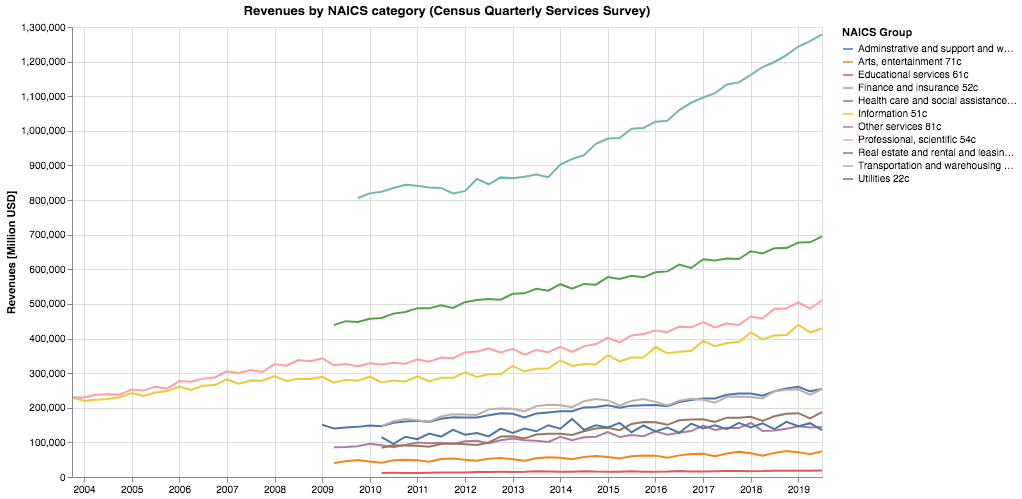

In [95]:
alt.Chart(categories_agg).mark_line().encode(
    alt.X('dt', axis=alt.Axis(title=None)),
    alt.Y('value:Q', axis=alt.Axis(title='Revenues [Million USD]')),
    alt.Color('variable:N', title="NAICS Group")
).properties(
    title="Revenues by NAICS category (Census Quarterly Services Survey)",
    background="white",
    width=750,
    height=450
)

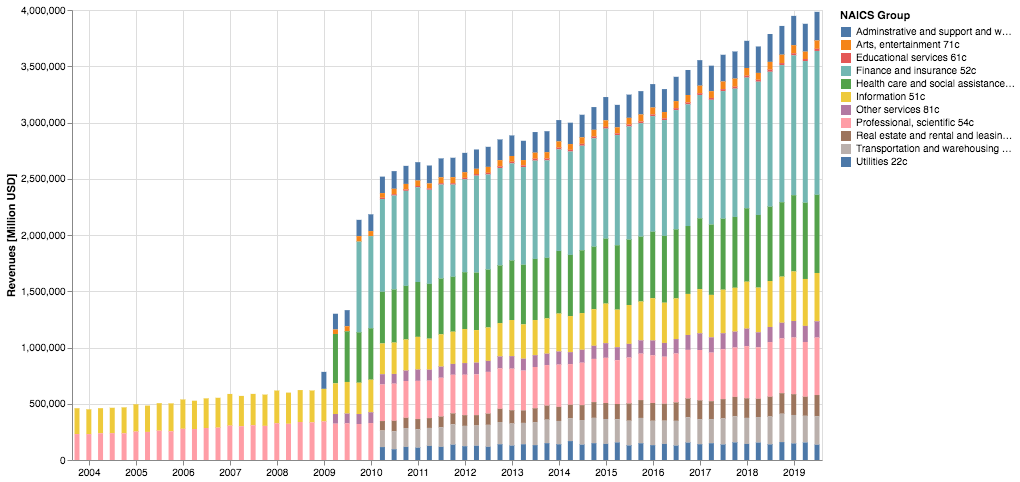

In [97]:
alt.Chart(categories_agg).mark_bar().encode(
    alt.X('dt:T', axis=alt.Axis(title=None)),
    alt.Y('value:Q', axis=alt.Axis(title='Revenues [Million USD]')),
    alt.Color('variable:N', title="NAICS Group")
).properties(
    background="white",
    width=750,
    height=450
)

In [ ]:
# TODO:

# - Correct these values for inflation
# - Try to correlate tax revenues per sector with each sectors' contribution to GDP

In [98]:
apiKey = open("/Users/kyledunn/fredApiKey.txt", "r").read().strip()

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
    
def getSeries(series="", apiKey=apiKey, description=None):
    fetchCommand = "https://api.stlouisfed.org/fred/series/observations?series_id={s}&realtime_end=9999-12-31&api_key={k}&file_type=txt" 
    
    resp = urlopen(fetchCommand.format(s=series, k=apiKey))
    zipfile = ZipFile(BytesIO(resp.read()))
    
    filesInZip = zipfile.namelist()
    
    data = zipfile.open(filesInZip[1])
    
    if description is None:
        description = series
    
    df = pd.read_csv(data, sep="\t", header=None, skiprows=1,
                       names=["date", description, "rt_start", "rt_end"], na_values=".")
    
    df['date'] = pd.to_datetime(df.date)
    
    df = df.set_index("date")
    
    return df[~df.index.duplicated(keep='first')]

In [99]:
df_cpi = getSeries("CWUR0000SA0", apiKey)
df_ppi = getSeries("PPIACO", apiKey)

In [ ]:
df_ppi.PPIACO.head()

In [100]:
infl_adj = (categories_agg.set_index('dt').value / (df_ppi.PPIACO.resample('3m').first() / 100.))
infl_adj.name = 'value_adj'

In [101]:
df_ppi.PPIACO.resample('1m').first().loc['2003-10-31']

df_ppi.index.get_loc(pd.to_datetime('2003-10-01'), method='nearest')

1089

In [102]:
def adjustValueWithDate(val, date):
    return val / (df_ppi.iloc[df_ppi.index.get_loc(pd.to_datetime(date), method='nearest')]['PPIACO'] / 100.)

adj_categories_agg = pd.DataFrame.from_records([(dt, variable, value, adjustValueWithDate(value, dt))
                                                for ix, dt, variable, value in categories_agg.itertuples()])
adj_categories_agg.columns = ['dt', 'variable', 'value', 'value_adj']

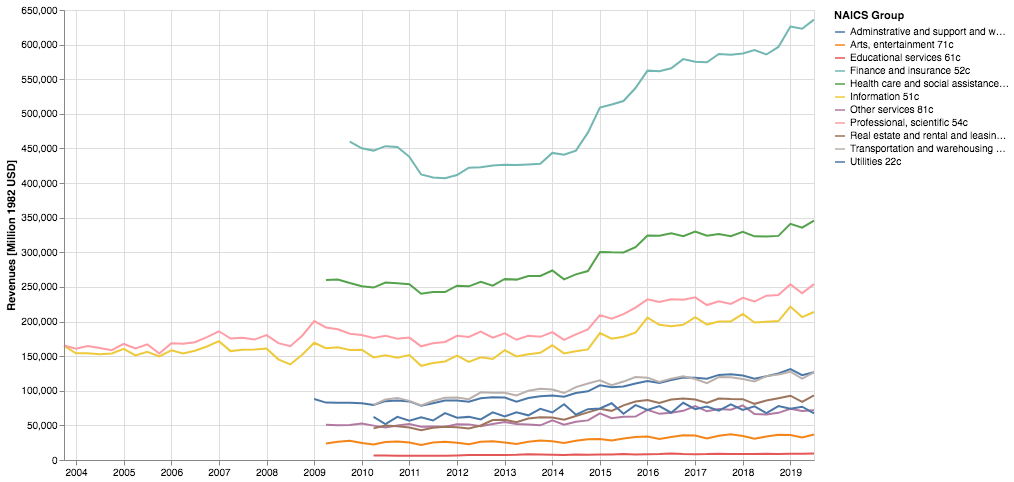

In [103]:
alt.Chart(adj_categories_agg).mark_line().encode(
    alt.X('dt', axis=alt.Axis(title=None)),
    alt.Y('value_adj:Q', axis=alt.Axis(title='Revenues [Million 1982 USD]')),
    alt.Color('variable:N', title="NAICS Group")
).properties(
    width=750,
    height=450
)

In [121]:
def getEmploymentSeries(seriesId="CEU5500000001", name="financial activities"):
    # Finance and insurance
    url = 'https://data.bls.gov/timeseries/{}?amp%222bdata_tool=XGtable&output_view=data&from_year=1990&to_year=2019'
    furl = url.format(seriesId)
    #print(furl)
    df_employment = pd.read_html(furl)[1]
    #print(df_employment.head())
    df_employment.columns = ['Year'] + df_employment.columns.tolist()[1:]
    
    df_emp = df_employment.iloc[:, :-1].melt(id_vars='Year')

    df_emp = df_emp[df_emp.Year != 'P : preliminary']

    df_emp['Date'] = pd.to_datetime(df_emp['variable'] + " " + df_emp['Year'], format="%b %Y")
    df_emp[name] = pd.to_numeric(df_emp['value'], errors='coerce')
    
    #print(df_emp.head(1))
    
    return df_emp[['Date', name]].sort_values('Date').set_index('Date').copy()

In [122]:
dfs_employment = []

industries = {
    'goods-producing': 'CEU0600000001',
    'mining and logging': 'CEU1000000001',
    'construction': 'CEU2000000001',
    'manufacturing': 'CEU3000000001',
    'retail trade': 'CEU4200000001',
    'transportation and warehousing': 'CEU4300000001',
    'information': 'CEU5000000001',
    'financial activities': 'CEU5500000001',
    'professional services': 'CEU6000000001',
    'education and health': 'CEU6500000001',
    'government': 'CEU9000000001'
}

for i in industries.keys():
    dfs_employment.append(getEmploymentSeries(industries[i], i))
    
df_employment = pd.concat(dfs_employment, axis=1)

In [123]:
exclude = [
    'Adminstrative and support and waste management 56c',
    'Arts, entertainment 71c',
    'Other services 81c',
    'Utilities 22c',
    'Real estate and rental and leasing 53c',
    'Educational services 61c'
]

def computeDollarsPerCapita(val, variable, date):
    if variable == 'Information 51c':
        return val / df_employment.iloc[df_employment.index.get_loc(pd.to_datetime(date), method='nearest')]['information']
    elif variable == 'Finance and insurance 52c':
        return val / df_employment.iloc[df_employment.index.get_loc(pd.to_datetime(date), method='nearest')]['financial activities']
    elif variable == 'Health care and social assistance 62c':
        return val / df_employment.iloc[df_employment.index.get_loc(pd.to_datetime(date), method='nearest')]['education and health']
    elif variable == 'Professional, scientific 54c':
        return val / df_employment.iloc[df_employment.index.get_loc(pd.to_datetime(date), method='nearest')]['professional services']
    elif variable == 'Transportation and warehousing 48-49c':
        return val / df_employment.iloc[df_employment.index.get_loc(pd.to_datetime(date), method='nearest')]['transportation and warehousing']

revenue_per_employee = pd.DataFrame.from_records([(dt, variable, value, computeDollarsPerCapita(value_adj, variable, dt))
                                                for ix, dt, variable, value, value_adj in adj_categories_agg[~adj_categories_agg.variable.isin(exclude)].itertuples()])

revenue_per_employee.columns = ['dt', 'variable', 'value', 'value_adj']

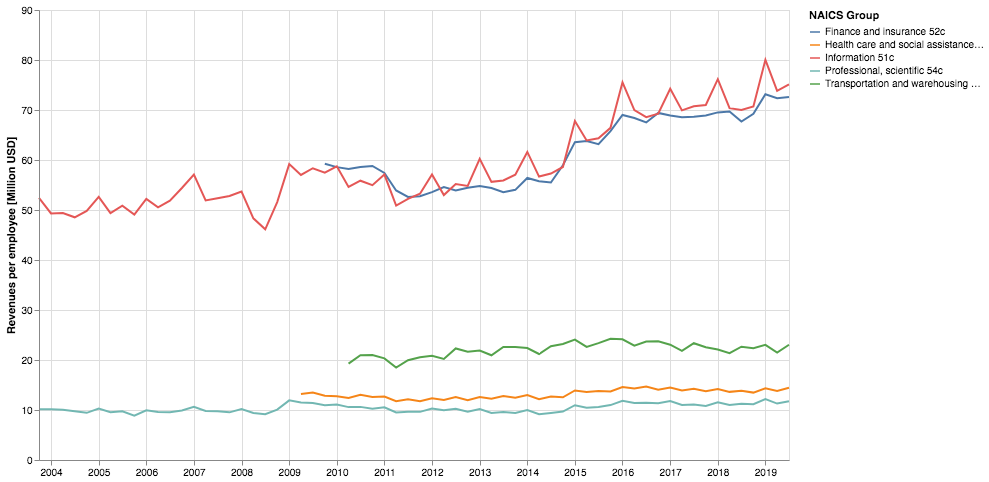

In [126]:
alt.Chart(revenue_per_employee).mark_line().encode(
    alt.X('dt', axis=alt.Axis(title=None)),
    alt.Y('value_adj:Q', axis=alt.Axis(title='Revenues per employee [Million USD]')),
    alt.Color('variable:N', title='NAICS Group')
).properties(
    background="white",
    width=750,
    height=450
)